In [1]:
import tensorflow as tf
from tensorflow.contrib import slim

import numpy as np

import time

from PIL import Image
from matplotlib import gridspec
from matplotlib import pyplot as plt
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
log_dir = '/Users/nikki/Desktop/models/research/deeplab/graph/1/'
model_dir_path = '/Users/nikki/Development/deeplab-img-segmentation/model_graph/deeplabv3_pascal_train_aug/'

LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

In [3]:
def create_color_map(num_labels):
    colormap = np.zeros((num_labels, 3), dtype=np.uint8)
    for i in range(num_labels):
        colormap[i, :] = i * 10
    return colormap

In [4]:
def visualize_seg(image, seg_map):
    color_map = create_color_map(len(LABEL_NAMES))
    
    plt.figure(figsize=(20, 5))

    plt.subplot(141)
    plt.imshow(image)
    plt.axis('off')
    
    plt.subplot(142)
    plt.imshow(image)
    plt.imshow(color_map[seg_map], alpha=0.8)
    plt.axis('off')
    
    plt.subplot(143)
    plt.imshow(color_map[seg_map])
    plt.axis('off')
    
    unique_labels = np.unique(seg_map)
    plt.subplot(144)
    plt.imshow([color_map[unique_labels]], interpolation='nearest')
    plt.xticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.grid('off')

In [5]:
def resize_img(image):
    INPUT_SIZE = 513
    
    width, height = image.size
    resize_ratio = 1.0 * INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    
    return resized_image

In [6]:
def pad_to_bounding_box(sess, image):
    img_placeholder = tf.placeholder(shape=(None, None, 3), dtype=tf.float32)
    
    rrr = tf.constant(shape=[1], dtype=tf.float32, value=127.5)
    qq = img_placeholder - rrr
    
    resized_img = tf.image.pad_to_bounding_box(image=qq, 
                                               offset_height=0, 
                                               offset_width=0, 
                                               target_height=513,
                                              target_width=513)
    
    rezzz = resized_img + rrr
    
    res_img = sess.run(rezzz, feed_dict={img_placeholder: image})
    return res_img

In [7]:
class DeepLab(object):
    OUTPUT_TENSOR_NAME_PAD = 'Pad:0'
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    
    
    INPUT_TENSOR_NAME_ADD = 'add_2:0'
    OUTPUT_TENSOR_NAME_TEST = 'SemanticPredictions/size:0'
    
    DECODER_OUTPUT_TENSOR = 'decoder/decoder_conv1_pointwise/Relu:0'
    
    def __init__(self):
        self.graph = tf.Graph()

        file = open(model_dir_path + 'frozen_inference_graph.pb', mode='rb')
        graph_def = tf.GraphDef.FromString(file.read())
        file.close()

        if graph_def is None:
            raise RuntimeError('Cannot find inference graph.')

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')

        self.sess = tf.Session(graph=self.graph)


    def run(self, image):
        t0 = time.time()
        
        resized_image = resize_img(image=image)
        width, height = resized_image.size
        
        with tf.Session() as sess:
            bounded_image = pad_to_bounding_box(sess, resized_image)
        
        # 1x129x129x256
        decoder_output = self.sess.run(
            'logits/semantic/BiasAdd:0',
            feed_dict={
                       self.INPUT_TENSOR_NAME_ADD: bounded_image,
                       self.OUTPUT_TENSOR_NAME_TEST: np.array([1, height, width])
                    })
        
        with tf.Session() as sess:
            # 1x129x129x21
#             logits = slim.conv2d(decoder_output, num_outputs=21, kernel_size=1)
            
            upsampled_logits = tf.image.resize_bilinear(images=decoder_output, size=(513, 513), align_corners=True)
            prediction = tf.argmax(upsampled_logits, axis=3)
            seg_map_tensor = tf.slice(input_=prediction, begin=(0, 0, 0), size=[1, height, width])
            
            
            sess.run(tf.global_variables_initializer())
            seg_map = sess.run(seg_map_tensor)[0]
            
        print(time.time() - t0)
        return resized_image, seg_map
        
    
    def save_graph(self):
        writer = tf.summary.FileWriter(logdir=log_dir+'my_net', graph=self.graph)

In [ ]:
deeplab = DeepLab()

In [13]:
image = Image.open('/Users/nikki/Development/deeplab-img-segmentation/data/train_color_batch/170908_065647862_Camera_6.jpg')
resized_image, seg_map = deeplab.run(image)

13.775611877441406


In [14]:
print(seg_map.shape)

(410, 513)


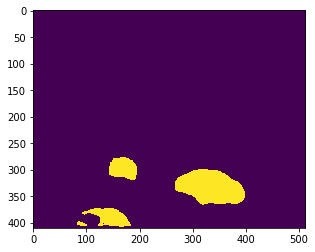

In [15]:
plt.imshow(seg_map)

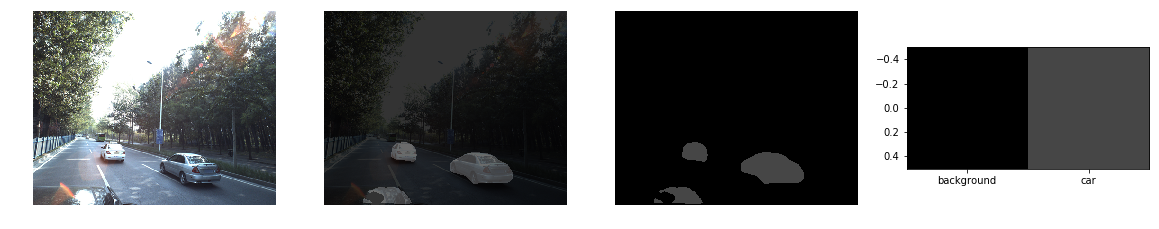

In [11]:
visualize_seg(resized_image, seg_map)

In [12]:
with tf.Session() as sess:
    upsampled_logits = tf.image.resize_bilinear(images=resized_image, size=(513, 513), align_corners=True)
    prediction = tf.argmax(upsampled_logits, axis=3)
    rrrresult = tf.slice(input_=prediction, begin=(0, 0, 0), size=[1, 384, 513])
    akk = sess.run(rrrresult)

ValueError: Shape must be rank 4 but is rank 3 for 'ResizeBilinear_1' (op: 'ResizeBilinear') with input shapes: [410,513,3], [2].

In [ ]:
print(akk.shape)

In [ ]:
plt.imshow(akk[0])

In [ ]:
with tf.Session() as sess:    
    res_img = pad_to_bounding_box(sess, resized_image)
    